In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA


from pynamics import downsample, downsample_split, avg_over, get_attractor_dimension
from pynamics.utils import np_cache, eigsort

from randnn import SparseRandNN, scaling_analysis
from hoogland_masters.plotting import *

rc('text', usetex=True)
logging.basicConfig(level=logging.ERROR)

## The model
$$\tau \frac{dh_i}{dt}=-h_i+\sum_{j=1}^N J_{ij}\phi(h_j),$$

#### "Fixed" Parameters
- $\tau$ is the characteristic timescale ($:=1$).
- $h_i$ is the activation of neuron $i$.
- $J_{ij}\sim \mathcal N(0, g^2/N)$ is the coupling matrix.
- $\phi$ is the activation function ($=\tanh$).

####  "Loose" Parameters
- $N$ is the number of neurons.
- $g$ is the coupling strength.
- $k$ is the (average) degree of the nodes
    - For the dense network, $k_0\equiv k_\text{dense}=N-1$ (no self-connections)
    - For the sparse network, $k_S= (N-1) \cdot (1-S)$, where
- $S$ is the sparsity coefficient (i.e., the fraction of edges to dilute to zero).


## How to compare sparse networks to dense networks?
1. **Vary $S$. Constant $g$ and $N$**: This is the naive option. The problem is that the average neuron will see have less input. Just like a network with a lower $g$  
2. **Vary $S$ and $g$. Constant $N$**:
    - $g':\quad g\cdot k_0 = g' \cdot k_S = \text{cst.}$ 
    - Here the problem is that $\phi$ is non-linear, so although the "average connective strength" is constant, the dynamic rule is changed. This might work better with threshold units (esp. linear ones)
3. **Vary $S$ and $N$. Constant $g$:** 
    - $N': \quad g\cdot k_0(N) = g \cdot k_S(N') = \text{cst.},$
    - where $k_S(N) = (N-1)\cdot (1-S)$
    - The average connection strength is the same per node & we're in the same range for $\phi$, but the network is of a different size.  
    - One problem is that the network size grows rapidly as $S\to 0$. This favors the other options.


Option 2 seems best (though I'll try all of the above). It's the same idea that Engelken et al. use to compare networks of different sizes.


In [2]:
# Shared parameters
N_STEPS = int(1e4)
N_DOFS = 1000

TIMESTEP = 1e-2
T_ONS = 1e-2
N_BURNIN_STEPS = 500
DOWNSAMPLE_RATE = 1

In [3]:
rc('text', usetex=False)

def measure_over_range(
    param_range: List[dict],
    n_steps: int = 10000,
    n_burn_in: int = 1000,
    n_samples: int = 10,
    **kwargs
):
    """
    A helper function for plotting vector measurements across ranges of
    coupling strength values. Each measurement will be plotted as a single curve.
:param observable: A function which takes a generated trajectory and
        the Trajectory object that generated it, and computes a
        measurement on it.
    :param n_dofs: The number of elements (neurons).
    :param n_steps: How many timesteps to simulate for each
        coupling_strength.
    :param n_burn_in: How many burnin timesteps to simulate before
        starting to record.
    :param kwargs:
    """
    results = []
    
    for i, params in enumerate(param_range):
        measurement_range = np.arange(N_DOFS)/N_DOFS
        measurements = np.zeros(N_DOFS)
        
        for j in range(n_samples):
            # 1. Initialize a network
            nn = SparseRandNN(**params,
                                network_seed = j,
                                **kwargs)

            # 2. Simulate a phase space trajectory
            trajectory = nn.run(n_steps=n_steps, n_burn_in=n_burn_in)[::DOWNSAMPLE_RATE]

            # 3. Perform your measurements
            measurements += nn.get_lyapunov_spectrum(trajectory, t_ons=T_ONS)

        measurements /= n_samples
            
        label = ", ".join(list(map(lambda vals: f"{vals[0]} {vals[1]}", params.items())))
        results.append([measurement_range, measurements, f"{i}. {label}"])

    return results


def plot_lyap_spec_over_range(params_range, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    results = measure_over_range(params_range, **kwargs)

    for [x, y, label] in results:
        ax.plot(x, y, label=label)

    del results

    plt.axhline(y=0., linestyle="--")

    ax.set_title(f"$g={kwargs['coupling_strength']}$")
    ax.set_ylabel("$\lambda_i$")
    ax.set_xlabel("$i/N$")
    ax.legend()
    

def plot_lyap_spec_over_double_range(outside_range, inside_range, **kwargs):
    for outside_params in outside_range:
        plot_lyap_spec_over_range(inside_range, **outside_params, **kwargs)
        plt.show()
    

## Shared parameters

In [4]:
SPARSITIES = [0., 0.5, 0.9] #, 0.1, 0.2, 0.5, 0.8, 0.9] #, 0.95, 0.99]
SPARSITIES_RANGE = list(map(lambda s: {"sparsity": s}, SPARSITIES))
GS_RANGE = list(map(lambda g: { "coupling_strength": g}, [1.5, 2., 3., 10.])) # 5., 20.])) #, 20.]))

## 1. Vary $S$, constant $g$ & $N$

HEY True True True b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 0 normalize:False>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-7a694ba9b58b13ee6ba2f5282847ab6b.npy
HEY True True True b"(array([[-8.94305076e-02,  2.20247864e-01, -6.65589835e-02, ...,\n         2.49010103e-01,  4.20085790e-01,  8.76104963e-01],\n       [-8.97841635e-02,  2.19738868e-01, -6.68132854e-02, ...,\n         2.48566688e-01,  4.20142920e-01,  8.76245937e-01],\n       [-9.01369068e-02,  2.19230310e-01, -6.70672154e-02, ...,\n         2.48123495e-01,  4.20200478e-01,  8.76386106e-01],\n       ...,\n       [ 1.07305428e+00, -7.40626941e-01,  5.22686601e-04, ...,\n         4.01985498e-01,  8.80432583e-02, -1.36096004e-01],\n       [ 1.07295734e+00, -7.41135738e-01,  3.94966289e-04, ...,\n         4.01603826e-01,  8.83821597e-02, -1.36015549e-01],\n       [ 1.07286029e+00, -7.41644510e-01,  2.67273566e-04, ...,\n         4.01222254e-01,  8.87210173e

KeyboardInterrupt: 

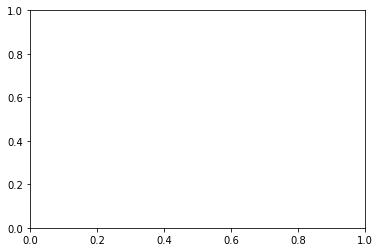

In [5]:
N_SAMPLES = 3
plot_lyap_spec_over_double_range(GS_RANGE, SPARSITIES_RANGE, n_dofs=N_DOFS, n_steps=N_STEPS, normalize_strength=False, n_samples=N_SAMPLES)

## 2. Vary $S$ & $g$, constant $g\cdot k$ & $N$

HEY True True True b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 0 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-85fa08503ed7322ef825c460de704ff6.npy
HEY True True False b"(array([[ 0.62869072, -0.34076823, -0.57068012, ...,  0.8243562 ,\n         0.14508231,  0.70008999],\n       [ 0.6285006 , -0.34112678, -0.57105744, ...,  0.82427952,\n         0.14490879,  0.70021942],\n       [ 0.62831011, -0.34148423, -0.57143372, ...,  0.82420308,\n         0.14473606,  0.70034893],\n       ...,\n       [-1.68468386,  0.02229368, -1.47704124, ...,  1.25486367,\n        -0.5393847 ,  0.21389328],\n       [-1.68471196,  0.02260937, -1.47708181, ...,  1.25460521,\n        -0.53973874,  0.21451584],\n       [-1.68473995,  0.02292492, -1.47712242, ...,  1.25434683,\n        -0.54009287,  0.21513833]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-e03e2a0d08223795656d893af3a19184.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   2%|▏         | 21/1000 [00:00<00:04, 206.15it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 1 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-3e4ca20496c66a62f67db1a4b34e3730.npy


Generating samples: 100%|██████████| 10000/10000 [00:28<00:00, 354.84it/s]


HEY True True False b"(array([[ 0.05166307,  0.52300138,  0.51656518, ...,  0.11214288,\n         0.06945342,  0.06157481],\n       [ 0.05160158,  0.52298884,  0.51660982, ...,  0.11233428,\n         0.06924267,  0.06114694],\n       [ 0.05154109,  0.52297664,  0.51665412, ...,  0.11252608,\n         0.06903194,  0.0607191 ],\n       ...,\n       [-0.16626452,  0.49415745, -0.7277849 , ...,  0.50936363,\n         0.27418223, -0.6489312 ],\n       [-0.16624459,  0.49408037, -0.72798237, ...,  0.5093229 ,\n         0.27412275, -0.64875111],\n       [-0.16622455,  0.49400321, -0.72817985, ...,  0.50928208,\n         0.27406333, -0.64857105]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-1d6c4b402deeb62296254dd85ba1facb.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   2%|▏         | 20/1000 [00:00<00:05, 192.13it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 2 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-2bd983fa17f067e16c6ae5cd808195af.npy


Generating samples: 100%|██████████| 10000/10000 [00:28<00:00, 356.47it/s]


HEY True True True b"(array([[-0.04630054,  0.02559814,  0.06570424, ...,  0.23722891,\n         0.66918574, -0.19064196],\n       [-0.04676587,  0.02496551,  0.06563006, ...,  0.23746578,\n         0.66885845, -0.19067444],\n       [-0.04723094,  0.02433304,  0.06555618, ...,  0.23770256,\n         0.66853055, -0.19070647],\n       ...,\n       [ 0.58164056, -0.44710147, -0.27286558, ..., -1.71957888,\n         0.90250114, -1.40263167],\n       [ 0.58128059, -0.44698141, -0.27292616, ..., -1.71972897,\n         0.90264621, -1.40341196],\n       [ 0.58092066, -0.4468612 , -0.27298673, ..., -1.71987915,\n         0.90279131, -1.40419222]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-e776436cf9bc4dc37b8fa7ca4f29c162.npy


Burning in:   4%|▎         | 37/1000 [00:00<00:02, 365.89it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 3 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-8e8a70b4dd59710e2fe95f3d1abfccd8.npy


Generating samples: 100%|██████████| 10000/10000 [00:37<00:00, 263.22it/s]


HEY True True False b"(array([[ 0.63508692,  0.56801657,  0.57510813, ..., -0.02563355,\n         0.15484799,  0.36797253],\n       [ 0.63502908,  0.56813093,  0.57501664, ..., -0.02590966,\n         0.15445832,  0.36746911],\n       [ 0.6349713 ,  0.56824523,  0.57492544, ..., -0.02618555,\n         0.15406901,  0.36696583],\n       ...,\n       [-0.57480419,  0.15643014,  0.38509316, ..., -0.5620916 ,\n        -0.36474397, -0.28416211],\n       [-0.57480547,  0.15663986,  0.3851563 , ..., -0.56201362,\n        -0.36472046, -0.28430448],\n       [-0.57480675,  0.15684936,  0.3852194 , ..., -0.56193529,\n        -0.36469699, -0.28444695]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-7aa8de1abfd36341eb60547aa7ff8c73.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 44/1000 [00:00<00:02, 438.55it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 4 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-d62318818999973f1a3017c484904410.npy


Generating samples: 100%|██████████| 10000/10000 [00:24<00:00, 416.25it/s]


HEY True True True b"(array([[ 0.31196241, -0.33062928,  0.92756861, ...,  0.47646897,\n        -0.54439494,  0.12562363],\n       [ 0.31189348, -0.33104037,  0.92747214, ...,  0.47613165,\n        -0.54492947,  0.12528265],\n       [ 0.31182467, -0.33145062,  0.92737476, ...,  0.47579473,\n        -0.54546324,  0.12494225],\n       ...,\n       [-0.12012718,  1.22608458, -1.55051412, ...,  0.54968432,\n         0.76153402,  0.05692959],\n       [-0.11995156,  1.22551064, -1.55034371, ...,  0.54938222,\n         0.76160022,  0.05705001],\n       [-0.11977612,  1.22493655, -1.55017312, ...,  0.54908015,\n         0.76166642,  0.05717039]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-827a335d36675dee1d25d30981f45dc2.npy


Burning in:   5%|▍         | 46/1000 [00:00<00:02, 454.59it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 5 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-3ebcdbf76651e52b35e2d9dd75b763bc.npy


Generating samples: 100%|██████████| 10000/10000 [00:23<00:00, 425.97it/s]


HEY True True False b"(array([[ 0.07854529, -0.23212595,  0.37949256, ...,  0.5780717 ,\n         0.70004086, -0.45798027],\n       [ 0.07858576, -0.23251209,  0.37917856, ...,  0.57841749,\n         0.70007415, -0.45806604],\n       [ 0.0786261 , -0.23289824,  0.37886451, ...,  0.57876362,\n         0.70010752, -0.45815114],\n       ...,\n       [-0.77234221,  1.69036325,  0.27615074, ..., -0.30929906,\n        -0.20542088, -0.00907094],\n       [-0.77253808,  1.69058997,  0.27623112, ..., -0.30914516,\n        -0.20537465, -0.00926818],\n       [-0.77273384,  1.69081666,  0.27631147, ..., -0.30899129,\n        -0.20532839, -0.00946556]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-a2964495c5ad9565942634a97214d5eb.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:  10%|▉         | 99/1000 [00:00<00:01, 498.32it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 6 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-aac318b5849f43e3ea72c5e9d68ab85b.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 435.11it/s]


HEY True True True b"(array([[ 0.39948837,  0.0796553 ,  0.54621812, ...,  0.40450012,\n        -0.12967117,  0.11413705],\n       [ 0.39909043,  0.07935146,  0.5460546 , ...,  0.4044646 ,\n        -0.1303222 ,  0.1140687 ],\n       [ 0.39869266,  0.0790481 ,  0.54589122, ...,  0.40442859,\n        -0.13097292,  0.11400008],\n       ...,\n       [ 0.24776576,  0.18471797,  2.16230601, ...,  0.97721071,\n        -0.29815292, -0.04102513],\n       [ 0.2481146 ,  0.18503827,  2.16234038, ...,  0.97711619,\n        -0.29808647, -0.04109246],\n       [ 0.24846317,  0.18535856,  2.16237475, ...,  0.97702168,\n        -0.29801986, -0.04115973]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-1cb83e6d3d3ff5c5d719382967c6e61a.npy


Burning in:   4%|▍         | 45/1000 [00:00<00:02, 447.01it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 7 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-f0941a65a74829292f4c02d94a4e0a3e.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 435.33it/s]


HEY True True False b"(array([[ 0.49578578,  0.39267147, -0.10762811, ..., -0.50422242,\n        -0.3574852 , -0.12902387],\n       [ 0.49577612,  0.392231  , -0.10817072, ..., -0.50421294,\n        -0.35802224, -0.12919214],\n       [ 0.49576663,  0.39178995, -0.10871287, ..., -0.50420283,\n        -0.35855891, -0.1293592 ],\n       ...,\n       [-0.90248229,  0.6243074 ,  0.11462818, ..., -0.48549946,\n        -0.08143899,  1.22188588],\n       [-0.90227389,  0.62450095,  0.11445543, ..., -0.48543335,\n        -0.08155521,  1.22206753],\n       [-0.90206534,  0.62469447,  0.11428273, ..., -0.48536731,\n        -0.08167147,  1.22224913]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-53c3c3c5c7a3a6a7e80156461b31b6fa.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   3%|▎         | 29/1000 [00:00<00:03, 285.82it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 8 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-c88fa4acad558b8d819db324987edc6a.npy


Generating samples: 100%|██████████| 10000/10000 [00:31<00:00, 322.25it/s]


HEY True True True b"(array([[ 5.41564229e-01,  4.27020921e-01,  2.50001848e-01, ...,\n         3.58702405e-01,  4.48974968e-01,  4.26525363e-02],\n       [ 5.41846168e-01,  4.27210095e-01,  2.50368149e-01, ...,\n         3.58366835e-01,  4.48987374e-01,  4.25811935e-02],\n       [ 5.42127796e-01,  4.27399273e-01,  2.50734642e-01, ...,\n         3.58031078e-01,  4.48999667e-01,  4.25098588e-02],\n       ...,\n       [-3.42878586e-01, -5.65556160e-01,  4.11711740e-01, ...,\n        -1.98670120e-03,  1.81265285e+00,  9.16615379e-01],\n       [-3.42885828e-01, -5.65550467e-01,  4.11626191e-01, ...,\n        -1.74755909e-03,  1.81296293e+00,  9.16811330e-01],\n       [-3.42892996e-01, -5.65544659e-01,  4.11540804e-01, ...,\n        -1.50842050e-03,  1.81327293e+00,  9.17007093e-01]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-098f395bd47e0abff5fd658a9f21e6c4.npy


Burning in:   3%|▎         | 30/1000 [00:00<00:03, 298.77it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 9 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-4cfb208cc4c3685bff61429042569653.npy


Generating samples: 100%|██████████| 10000/10000 [00:30<00:00, 324.02it/s]


HEY True True False b"(array([[ 0.35527206,  0.20624495,  0.61207618, ..., -0.29727974,\n        -0.23632457,  0.34999154],\n       [ 0.35492381,  0.20632436,  0.61200852, ..., -0.29781645,\n        -0.23722155,  0.34952614],\n       [ 0.35457574,  0.20640405,  0.61194112, ..., -0.29835234,\n        -0.23811819,  0.34906069],\n       ...,\n       [-1.56077664, -0.90511903, -2.07974124, ...,  0.8247371 ,\n        -1.53996744,  0.46451603],\n       [-1.56053537, -0.90512354, -2.07950887, ...,  0.82483866,\n        -1.53968298,  0.46472315],\n       [-1.56029412, -0.90512803, -2.07927647, ...,  0.82494018,\n        -1.53939843,  0.46493024]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-d1a9f6bae829d28f0c08f681918c267b.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▎         | 37/1000 [00:00<00:02, 364.04it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 0 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-dfa198bae2b635c6209deec673258491.npy


Generating samples: 100%|██████████| 10000/10000 [00:26<00:00, 379.36it/s]


HEY True True False b"(array([[ 0.15963451,  0.27387988, -0.06986095, ...,  0.12586029,\n         0.16176533,  0.26684016],\n       [ 0.15972535,  0.27370496, -0.07015277, ...,  0.1253477 ,\n         0.16158929,  0.26685089],\n       [ 0.15981639,  0.27352992, -0.07044458, ...,  0.12483585,\n         0.16141325,  0.2668619 ],\n       ...,\n       [-1.16171271,  0.14485066, -1.02875599, ...,  0.74362231,\n         0.13980492, -0.62611511],\n       [-1.1615674 ,  0.14513033, -1.02864336, ...,  0.74366231,\n         0.13955222, -0.62610663],\n       [-1.16142188,  0.14541002, -1.02853074, ...,  0.74370216,\n         0.13929934, -0.62609815]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-d91d8c9fb2887cc85c169dcee451a300.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   3%|▎         | 32/1000 [00:00<00:03, 315.40it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 1 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-878aa4acf95d3f4c30991f003e2ca5b2.npy


Generating samples: 100%|██████████| 10000/10000 [00:36<00:00, 273.24it/s]


HEY True True False b"(array([[ 0.66190554,  0.42453798,  0.41751481, ..., -0.00788829,\n        -0.31263282,  0.32300781],\n       [ 0.66230521,  0.42435196,  0.41722779, ..., -0.0076163 ,\n        -0.31326523,  0.3229139 ],\n       [ 0.66270527,  0.42416597,  0.41694094, ..., -0.00734401,\n        -0.31389733,  0.32282019],\n       ...,\n       [ 0.1644396 , -0.03262688, -0.58278543, ...,  0.55157217,\n         0.02432467,  0.51683701],\n       [ 0.16453971, -0.03260903, -0.58274016, ...,  0.55150009,\n         0.02447515,  0.51694013],\n       [ 0.16463974, -0.03259117, -0.58269476, ...,  0.55142803,\n         0.02462576,  0.51704326]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-9b236fe8ed258297b6af0ff1f86455e6.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 39/1000 [00:00<00:02, 386.02it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 2 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-547eb04d07cc04ce0cc5589fa92503db.npy


Generating samples: 100%|██████████| 10000/10000 [00:23<00:00, 423.25it/s]


HEY True True False b"(array([[-0.05705307, -0.06094061,  0.37089021, ...,  0.70743564,\n         0.82276478,  0.27403314],\n       [-0.05762374, -0.06146911,  0.37092916, ...,  0.70769204,\n         0.82285456,  0.2745351 ],\n       [-0.05819431, -0.06199721,  0.37096797, ...,  0.70794782,\n         0.82294404,  0.27503736],\n       ...,\n       [-0.44322067,  0.94508661, -1.18272661, ..., -0.38525864,\n        -1.3133285 ,  0.85414968],\n       [-0.44348198,  0.94490696, -1.18254731, ..., -0.38547814,\n        -1.31390347,  0.85403672],\n       [-0.44374355,  0.94472705, -1.18236782, ..., -0.38569754,\n        -1.31447851,  0.8539238 ]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-55249447d5dba985a3c5306d130d6f44.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 45/1000 [00:00<00:02, 448.56it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 3 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-4a7db1c9b5e200987d3a66abf059a647.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 435.84it/s]


HEY True True False b"(array([[ 0.52353008,  0.68931806,  0.07581651, ...,  0.01027399,\n         0.41590154,  0.63337655],\n       [ 0.52350084,  0.68911247,  0.07584564, ...,  0.00947261,\n         0.4152501 ,  0.63322741],\n       [ 0.52347144,  0.68890686,  0.07587542, ...,  0.00867186,\n         0.41459852,  0.63307818],\n       ...,\n       [-1.36929974,  0.37833835,  0.13214977, ..., -0.40632268,\n         0.21076486,  0.96685074],\n       [-1.36931693,  0.37846495,  0.13229123, ..., -0.40630548,\n         0.21065026,  0.96672228],\n       [-1.36933415,  0.37859147,  0.13243272, ..., -0.40628822,\n         0.21053568,  0.96659375]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-1d44dab5252f022e5adefad050c9dee2.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   3%|▎         | 34/1000 [00:00<00:02, 338.63it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 4 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-489728ad11c4e4f1db4012f48986e94e.npy


Generating samples: 100%|██████████| 10000/10000 [00:24<00:00, 411.12it/s]


HEY True True False b"(array([[ 0.46301271, -0.06530909,  0.6583444 , ...,  0.47232042,\n        -0.45884173,  0.21411866],\n       [ 0.46300429, -0.06586749,  0.65842189, ...,  0.4719743 ,\n        -0.45919278,  0.2135079 ],\n       [ 0.46299573, -0.06642554,  0.6584993 , ...,  0.47162874,\n        -0.45954286,  0.2128973 ],\n       ...,\n       [ 0.36628868, -0.25764241, -1.04658647, ..., -0.07575428,\n         1.40152401,  0.48822805],\n       [ 0.36640287, -0.25768145, -1.04679528, ..., -0.07596493,\n         1.40150098,  0.48812556],\n       [ 0.36651704, -0.25772048, -1.04700404, ..., -0.07617558,\n         1.40147784,  0.48802309]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-2db000c487c635320d260b01d0ac6c18.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 47/1000 [00:00<00:02, 469.71it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 5 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-29bef3b8e1c4991c36022da6f10766c0.npy


Generating samples: 100%|██████████| 10000/10000 [00:21<00:00, 461.77it/s]


HEY True True False b"(array([[ 0.68561993,  0.1304738 ,  0.35308212, ..., -0.2348909 ,\n         0.87519228, -0.01852621],\n       [ 0.68561696,  0.13026658,  0.35254941, ..., -0.23514138,\n         0.87494144, -0.01863263],\n       [ 0.68561395,  0.13005984,  0.35201721, ..., -0.23539116,\n         0.87469056, -0.0187391 ],\n       ...,\n       [-1.04374624, -0.58954662,  0.57093654, ..., -0.90472468,\n         0.78632786,  0.12835891],\n       [-1.04384587, -0.58978833,  0.57092038, ..., -0.90507259,\n         0.78625382,  0.12801757],\n       [-1.04394554, -0.59002996,  0.570904  , ..., -0.90542042,\n         0.78617966,  0.1276762 ]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-5c84217e2a27e745bdcc1f3649254cdc.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 49/1000 [00:00<00:01, 484.83it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 6 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-8012c63a02c20705a0556b38c75e1df7.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 452.93it/s]


HEY True True False b"(array([[ 0.20739813,  0.26747956,  0.45860842, ..., -0.09649688,\n         0.11810298,  0.27014804],\n       [ 0.20660148,  0.26714401,  0.45850517, ..., -0.09710636,\n         0.11789358,  0.2703323 ],\n       [ 0.20580474,  0.26680833,  0.45840235, ..., -0.0977161 ,\n         0.11768461,  0.27051634],\n       ...,\n       [ 0.95372369, -1.13271056, -0.0425277 , ..., -0.86212566,\n         2.78879434,  0.34989009],\n       [ 0.95380457, -1.13289621, -0.0428325 , ..., -0.86204873,\n         2.78874044,  0.34985638],\n       [ 0.9538853 , -1.13308177, -0.04313731, ..., -0.86197175,\n         2.78868641,  0.34982261]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-b35f098f99aa78aa17f51506dbce4789.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 45/1000 [00:00<00:02, 443.24it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 7 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-9316f35afa5e83fe32ecdbf81fc233fc.npy


Generating samples: 100%|██████████| 10000/10000 [00:21<00:00, 457.88it/s]


HEY True True False b"(array([[ 0.36942702,  0.60968385,  0.38185977, ..., -0.21642499,\n        -0.24251588,  0.49539233],\n       [ 0.36934   ,  0.60957271,  0.38134663, ..., -0.2162852 ,\n        -0.24335438,  0.49509828],\n       [ 0.36925282,  0.60946109,  0.38083362, ..., -0.21614494,\n        -0.24419208,  0.49480414],\n       ...,\n       [-0.40967771, -0.28173268,  0.46780783, ..., -0.79999701,\n        -0.87047268,  0.38352113],\n       [-0.40945257, -0.28148312,  0.46755456, ..., -0.7997662 ,\n        -0.87052495,  0.38341224],\n       [-0.40922738, -0.28123377,  0.46730125, ..., -0.79953527,\n        -0.87057728,  0.38330326]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-359d67a43d991c53f09959e5c454ee74.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 45/1000 [00:00<00:02, 447.00it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 8 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-401230bd76321845dcc6e7fe73d48bf4.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 450.11it/s]


HEY True True False b"(array([[ 0.05623774,  0.01097799,  0.27901289, ...,  0.73299519,\n        -0.04559277,  0.07612099],\n       [ 0.05571344,  0.0108334 ,  0.27905127, ...,  0.73309262,\n        -0.04613826,  0.07616468],\n       [ 0.05518885,  0.01068926,  0.27908946, ...,  0.73318951,\n        -0.0466839 ,  0.07620845],\n       ...,\n       [ 0.11514066, -0.92568193,  0.38994499, ..., -0.55016882,\n        -2.16675267, -0.69087868],\n       [ 0.11497321, -0.92561133,  0.38982254, ..., -0.54982367,\n        -2.16661616, -0.69106017],\n       [ 0.11480572, -0.92554068,  0.38970017, ..., -0.54947853,\n        -2.1664796 , -0.69124157]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-ebda0acf153c356ce8cf74527df69d12.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 47/1000 [00:00<00:02, 461.68it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 9 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-96ce46f133134e7f82631b091fd96b36.npy


Generating samples: 100%|██████████| 10000/10000 [00:21<00:00, 456.61it/s]


HEY True True False b"(array([[ 0.22647241, -0.04115974,  0.51345707, ..., -0.68636342,\n         0.56749293,  0.27129409],\n       [ 0.22599017, -0.04180361,  0.51343004, ..., -0.6869059 ,\n         0.56724802,  0.27133697],\n       [ 0.22550797, -0.04244689,  0.51340315, ..., -0.68744728,\n         0.5670035 ,  0.27137991],\n       ...,\n       [-0.66878678,  0.76232014,  0.77239143, ...,  0.85719052,\n         0.68261034, -0.70171908],\n       [-0.66892608,  0.76244075,  0.77242048, ...,  0.85705669,\n         0.68200918, -0.70177676],\n       [-0.66906526,  0.76256141,  0.77244955, ...,  0.85692279,\n         0.68140808, -0.70183434]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-6f6a2892da3687c39c2555d820848691.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   9%|▉         | 90/1000 [00:00<00:02, 446.66it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 0 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-396241ce9cbb0b2e21d93e5d5782971d.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 440.12it/s]


HEY True True False b"(array([[ 5.72496156e-02,  3.14109155e-01, -1.62192911e-04, ...,\n         4.00663674e-01, -2.36700279e-01,  7.39683693e-01],\n       [ 5.70999201e-02,  3.14002081e-01, -7.00103210e-04, ...,\n         4.00423002e-01, -2.36848339e-01,  7.39862108e-01],\n       [ 5.69499991e-02,  3.13895115e-01, -1.23805388e-03, ...,\n         4.00182664e-01, -2.36995819e-01,  7.40040380e-01],\n       ...,\n       [-1.22463083e+00, -1.33144849e+00,  9.73510986e-01, ...,\n         2.96347688e-01, -3.49827473e-01,  1.01433551e+00],\n       [-1.22469860e+00, -1.33139735e+00,  9.73504387e-01, ...,\n         2.96280485e-01, -3.50306282e-01,  1.01432638e+00],\n       [-1.22476612e+00, -1.33134615e+00,  9.73497830e-01, ...,\n         2.96213339e-01, -3.50785057e-01,  1.01431722e+00]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-3f90c3c13a99c4cb1a325fbc21a894d0.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 46/1000 [00:00<00:02, 458.35it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 1 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-c6937f71958df198e64536724f3e708a.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 449.35it/s]


HEY True True False b"(array([[ 0.00318591,  0.76061245,  0.57380508, ..., -0.27173743,\n        -0.11643237, -0.30801197],\n       [ 0.00254102,  0.76063791,  0.57378789, ..., -0.27164463,\n        -0.116635  , -0.30866265],\n       [ 0.0018964 ,  0.76066362,  0.57377068, ..., -0.27155114,\n        -0.11683762, -0.30931289],\n       ...,\n       [-1.27347098, -0.82708235,  0.68074422, ...,  1.19167584,\n         1.04426613, -0.31221529],\n       [-1.27336278, -0.82707028,  0.68073206, ...,  1.1914695 ,\n         1.04436351, -0.31216637],\n       [-1.27325463, -0.82705816,  0.68071978, ...,  1.19126311,\n         1.04446078, -0.31211743]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-ece48c5a39a568112de1fb21333c55ae.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▌         | 50/1000 [00:00<00:01, 494.42it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 2 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-bf060d68c5826983de525f78b9dd7e45.npy


Generating samples: 100%|██████████| 10000/10000 [00:23<00:00, 433.15it/s]


HEY True True False b"(array([[ 0.17263895,  0.26380705,  0.20052671, ...,  0.64654065,\n        -0.44307414,  0.23060477],\n       [ 0.17219415,  0.26344393,  0.2006993 , ...,  0.64682661,\n        -0.44362674,  0.23084217],\n       [ 0.17174959,  0.26308092,  0.2008721 , ...,  0.64711228,\n        -0.44417845,  0.23107955],\n       ...,\n       [ 0.63336931, -1.20597253,  0.28740684, ...,  1.25953242,\n         0.17399264,  1.03350639],\n       [ 0.63338572, -1.20609608,  0.28742446, ...,  1.25982254,\n         0.17402842,  1.0334616 ],\n       [ 0.63340196, -1.20621965,  0.28744199, ...,  1.26011261,\n         0.17406428,  1.03341686]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-caa774f16db3e88ee5353d9ee67d0100.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 49/1000 [00:00<00:01, 482.21it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 3 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-1336ea35f9bfa36a7536ca9388884fff.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 445.63it/s]


HEY True True False b"(array([[ 0.58065531,  0.1402344 ,  0.39600316, ...,  0.3523718 ,\n         0.38301142,  0.56220837],\n       [ 0.58060209,  0.13978789,  0.3961302 , ...,  0.3520327 ,\n         0.3828029 ,  0.56210034],\n       [ 0.58054873,  0.1393414 ,  0.39625774, ...,  0.35169383,\n         0.38259467,  0.56199283],\n       ...,\n       [ 0.44724118,  0.23040976,  0.0580074 , ...,  0.49018541,\n        -0.92392075,  0.20843733],\n       [ 0.44736532,  0.23031939,  0.05780173, ...,  0.49035882,\n        -0.92399497,  0.20828258],\n       [ 0.4474894 ,  0.23022897,  0.05759617, ...,  0.49053219,\n        -0.92406912,  0.20812772]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-10f27f6331a40515224c2bc3788222ac.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 42/1000 [00:00<00:02, 416.39it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 4 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-660b61beb6dcc89a93f6feba96fe74fe.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 441.27it/s]


HEY True True False b"(array([[ 0.17585821,  0.30300058,  0.50735842, ...,  0.18146839,\n         0.28853189, -0.2973523 ],\n       [ 0.17567053,  0.30256143,  0.50729816, ...,  0.18088671,\n         0.28866003, -0.2981794 ],\n       [ 0.17548324,  0.30212235,  0.50723791, ...,  0.18030562,\n         0.28878816, -0.29900592],\n       ...,\n       [ 0.89742877,  0.89244451,  0.56478628, ...,  0.72516824,\n         0.95277406, -1.81279895],\n       [ 0.89736223,  0.89256752,  0.56482834, ...,  0.7253873 ,\n         0.95316571, -1.81237117],\n       [ 0.89729569,  0.8926904 ,  0.56487043, ...,  0.72560644,\n         0.9535572 , -1.8119432 ]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-f9be2546221d5c921b97041afe8050a8.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:  10%|▉         | 99/1000 [00:00<00:01, 490.84it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 5 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-b7c0b8d58c5ed9dcd64e023aae0d3297.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 446.11it/s]


HEY True True False b"(array([[ 0.41600585,  0.2397868 , -0.08165695, ..., -0.07372744,\n         0.49995523, -0.05169275],\n       [ 0.41600031,  0.23987312, -0.08188185, ..., -0.07363429,\n         0.4994565 , -0.05205582],\n       [ 0.41599519,  0.23996016, -0.0821059 , ..., -0.07354052,\n         0.49895789, -0.05241913],\n       ...,\n       [-0.27780881,  0.78706179,  0.22058495, ..., -0.35337329,\n         1.23387149, -0.24279668],\n       [-0.27786619,  0.78722211,  0.22025915, ..., -0.35334243,\n         1.23399711, -0.2428219 ],\n       [-0.27792357,  0.78738228,  0.21993338, ..., -0.35331156,\n         1.23412273, -0.24284709]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-ae214450970a622d8c159db53319d991.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 49/1000 [00:00<00:01, 483.35it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 6 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-ad98fdbdc373301e20263607db28cd8c.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 437.58it/s]


HEY True True False b"(array([[-0.03261099,  0.04215157,  0.70798153, ..., -0.16804204,\n         0.32218946,  0.02918481],\n       [-0.03280992,  0.04172633,  0.70762137, ..., -0.16838632,\n         0.32198307,  0.02922746],\n       [-0.03300784,  0.04130156,  0.70726086, ..., -0.1687307 ,\n         0.32177673,  0.02927007],\n       ...,\n       [ 0.73887467,  0.87735226, -0.17035325, ...,  0.85726659,\n        -0.2749916 , -0.47359477],\n       [ 0.73862197,  0.87756559, -0.1702645 , ...,  0.85736275,\n        -0.2747735 , -0.47336144],\n       [ 0.73836931,  0.87777887, -0.17017563, ...,  0.85745894,\n        -0.27455529, -0.47312807]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-5abd5a1285bf29d662b4b036bc30be24.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 48/1000 [00:00<00:02, 468.39it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 7 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-df1c29de4d2243731f601d9f5b30d9bb.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 447.32it/s]


HEY True True False b"(array([[ 0.39513691,  0.49469635,  0.24077898, ..., -0.14983477,\n         0.44568758,  0.85023143],\n       [ 0.39532171,  0.49462666,  0.24027084, ..., -0.14966708,\n         0.44534222,  0.85011037],\n       [ 0.39550634,  0.49455642,  0.23976263, ..., -0.14949902,\n         0.44499755,  0.8499891 ],\n       ...,\n       [-0.10357403, -0.72518913, -0.79146873, ...,  1.00799172,\n         0.22692694,  0.84836191],\n       [-0.10383462, -0.72527082, -0.7912944 , ...,  1.00777536,\n         0.22688238,  0.8480533 ],\n       [-0.10409514, -0.72535236, -0.79112005, ...,  1.00755909,\n         0.22683792,  0.84774467]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-7378b487e1f0966a8c0faa0a6a115427.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 49/1000 [00:00<00:01, 485.40it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 8 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-ec7a3248b3a02edd7caedafd2209ff1e.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 443.52it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]

HEY True True False b"(array([[ 0.26259111,  0.16888419,  0.42217373, ...,  0.36417629,\n         0.0284484 ,  0.35821687],\n       [ 0.26234257,  0.1686417 ,  0.42214576, ...,  0.36394871,\n         0.02801168,  0.35850875],\n       [ 0.2620941 ,  0.16839926,  0.42211718, ...,  0.36372143,\n         0.0275749 ,  0.35880068],\n       ...,\n       [ 0.68336684, -0.06335143, -0.39605005, ...,  1.32278874,\n        -1.27174309,  0.08439772],\n       [ 0.68332567, -0.06342433, -0.39610753, ...,  1.3227125 ,\n        -1.2717192 ,  0.08469188],\n       [ 0.68328447, -0.06349714, -0.39616505, ...,  1.32263625,\n        -1.27169524,  0.08498601]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-cf987f2840f126e8ccacd5ac296a306e.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:  10%|▉         | 98/1000 [00:00<00:01, 485.20it/s]

HEY True True False b"(<SparseRandNN coupling_strength:1.5 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 9 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-e913998cac09f46c28380ecfc3d8620c.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 451.27it/s]


HEY True True False b"(array([[ 0.52388344,  0.02982456,  0.24417196, ...,  0.19757425,\n         0.1013754 , -0.08762278],\n       [ 0.52340141,  0.02933682,  0.24411043, ...,  0.19742269,\n         0.10079132, -0.08810716],\n       [ 0.52291937,  0.02884984,  0.24404913, ...,  0.1972717 ,\n         0.10020773, -0.08859165],\n       ...,\n       [-1.12882299,  0.59444013, -0.46978906, ..., -0.53439457,\n        -1.22325432,  1.09398616],\n       [-1.12906304,  0.5943055 , -0.4698874 , ..., -0.53432209,\n        -1.2233382 ,  1.09405719],\n       [-1.12930296,  0.59417076, -0.46998559, ..., -0.53424966,\n        -1.22342205,  1.09412817]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-c20bf2e9ad6b8d6948d88ed65a67f84c.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 100%|██████████| 10000/10000 [13:19<00:00, 12.50it/s]


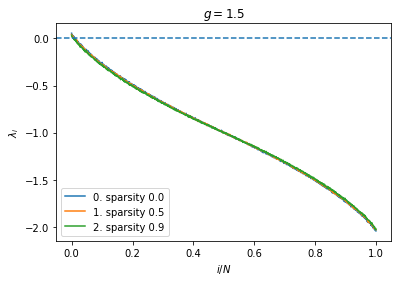

Burning in:   5%|▍         | 48/1000 [00:00<00:02, 474.52it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 0 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-f7cd5ebb42b2f4ba405ccc252df8a142.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 451.42it/s]


HEY True True True b"(array([[-0.44601693,  0.22551531,  0.10706298, ...,  0.14204869,\n         0.20830024,  0.72396567],\n       [-0.44589106,  0.22508736,  0.10715499, ...,  0.14172627,\n         0.20799408,  0.72366248],\n       [-0.44576391,  0.22465897,  0.10724639, ...,  0.14140462,\n         0.20768742,  0.72335792],\n       ...,\n       [ 3.05800145, -1.73521402, -1.15932695, ...,  1.84879053,\n         0.29064976,  0.45365682],\n       [ 3.05746289, -1.73510287, -1.15873051, ...,  1.84852473,\n         0.29004473,  0.45399111],\n       [ 3.05692416, -1.73499139, -1.1581344 , ...,  1.84825856,\n         0.28943937,  0.45432533]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-a55d5701accbb02317eb5dd4d71af56f.npy


Burning in:   5%|▍         | 48/1000 [00:00<00:01, 478.71it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 1 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-fe98e830fa0cf3712c4c012eafe325b6.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 445.29it/s]


HEY True True False b"(array([[ 0.57100513,  0.3075174 ,  0.47576451, ..., -0.20640839,\n        -0.40974352, -0.3672018 ],\n       [ 0.57168729,  0.30770376,  0.4754426 , ..., -0.20638601,\n        -0.41030551, -0.36814313],\n       [ 0.57236994,  0.30789052,  0.47512047, ..., -0.20636276,\n        -0.41086708, -0.36908369],\n       ...,\n       [-0.7177475 ,  0.83898785, -0.37863313, ...,  0.28808627,\n        -0.46617593, -0.82552799],\n       [-0.71738023,  0.83864231, -0.37850219, ...,  0.28759272,\n        -0.46589984, -0.82556935],\n       [-0.71701292,  0.83829647, -0.37837108, ...,  0.28709898,\n        -0.46562356, -0.82561087]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-90b65a556df31e4adb3103c9c0daf852.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 47/1000 [00:00<00:02, 464.48it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 2 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-76f49418428f9f5d44429e4e1d4f0c3f.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 441.79it/s]


HEY True True True b"(array([[-0.23630329, -0.1854149 ,  0.08049275, ...,  0.41143674,\n         0.7324306 , -0.24531245],\n       [-0.23702116, -0.18638243,  0.08051271, ...,  0.41187396,\n         0.73183386, -0.24526885],\n       [-0.2377387 , -0.18734994,  0.0805329 , ...,  0.41231066,\n         0.73123622, -0.24522481],\n       ...,\n       [ 0.51607745, -1.8491911 ,  0.48694214, ..., -2.51149973,\n         1.86146392, -2.39910501],\n       [ 0.51580946, -1.8489154 ,  0.48727216, ..., -2.5118163 ,\n         1.86199636, -2.40005139],\n       [ 0.51554168, -1.84863943,  0.48760195, ..., -2.51213314,\n         1.86252866, -2.40099762]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-a568e74fec94a175f8108c3233075eb2.npy


Burning in:   5%|▍         | 48/1000 [00:00<00:02, 474.83it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 3 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-1cbed8bf2f277bdcad5a3035c428f383.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 451.26it/s]


HEY True True False b"(array([[ 0.80148466,  0.78880033,  0.74720802, ..., -0.121441  ,\n         0.09583689,  0.29796513],\n       [ 0.80150476,  0.78910503,  0.74740021, ..., -0.1218253 ,\n         0.09543407,  0.29728049],\n       [ 0.80152445,  0.78940947,  0.74759298, ..., -0.12220944,\n         0.09503191,  0.2965961 ],\n       ...,\n       [-1.77266508,  0.6653926 ,  1.00344714, ..., -1.54913259,\n        -1.73066919, -0.77486586],\n       [-1.77260109,  0.66575014,  1.00352107, ..., -1.54895774,\n        -1.73130427, -0.77500741],\n       [-1.77253713,  0.66610715,  1.00359474, ..., -1.54878213,\n        -1.73193937, -0.77514899]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-2d7ea01b56a61973d71a2e77581ea9e4.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 43/1000 [00:00<00:02, 428.57it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 4 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-fd8c0a3de4b0e18b6ed636c003a4830d.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 441.31it/s]


HEY True True False b"(array([[ 0.37697036, -0.55578365,  1.16673303, ...,  0.5194318 ,\n        -0.86964181,  0.04165226],\n       [ 0.37700027, -0.55628333,  1.16646328, ...,  0.51914762,\n        -0.87039381,  0.04129161],\n       [ 0.37703043, -0.55678208,  1.16619157, ...,  0.51886399,\n        -0.8711448 ,  0.04093155],\n       ...,\n       [ 0.0598839 ,  1.56236983, -2.29679668, ...,  0.4472342 ,\n         0.17192796,  1.00821175],\n       [ 0.05996097,  1.56136181, -2.29624268, ...,  0.44690241,\n         0.17164136,  1.00875856],\n       [ 0.06003751,  1.56035359, -2.29568883, ...,  0.44657077,\n         0.17135512,  1.00930521]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-8381751f1da4cd6f558c23ec6f475e00.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 44/1000 [00:00<00:02, 430.65it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 5 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-01f77dadc1923804b3f98570bb691ea3.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 447.35it/s]


HEY True True False b"(array([[ 0.70745425,  0.10582252,  0.86264299, ...,  0.39811188,\n         0.79384825, -0.50571863],\n       [ 0.70755176,  0.10502627,  0.8626489 , ...,  0.3985903 ,\n         0.79404741, -0.50561746],\n       [ 0.7076494 ,  0.10422973,  0.86265524, ...,  0.39906956,\n         0.79424748, -0.50551564],\n       ...,\n       [-0.35400456,  2.47246297,  0.45686614, ..., -1.50711688,\n         0.97694418, -0.89809926],\n       [-0.35379894,  2.47262619,  0.4573354 , ..., -1.50704031,\n         0.97710917, -0.89836348],\n       [-0.35359317,  2.47278996,  0.45780491, ..., -1.5069639 ,\n         0.97727386, -0.89862754]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-a6c1352dc00573427203cb8eb1820396.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 48/1000 [00:00<00:02, 475.19it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 6 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-0e58380ded5de0d25d36382eb2be1025.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 448.88it/s]


HEY True True False b"(array([[ 0.3675032 ,  0.01270833,  0.67400561, ...,  0.5039177 ,\n        -0.39881693,  0.10413816],\n       [ 0.36693151,  0.01239667,  0.6739515 , ...,  0.50381866,\n        -0.39982371,  0.10391104],\n       [ 0.36635983,  0.01208555,  0.67389755, ...,  0.50371897,\n        -0.40083016,  0.10368318],\n       ...,\n       [ 1.53706224,  0.03718505,  4.72119956, ...,  2.71173629,\n        -0.1037592 , -0.33515613],\n       [ 1.53735351,  0.03787442,  4.7212737 , ...,  2.71136422,\n        -0.10343321, -0.33455309],\n       [ 1.53764464,  0.03856352,  4.72134779, ...,  2.7109921 ,\n        -0.10310685, -0.33394944]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-42ee041694f44d6145d66fa7088cffbc.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▌         | 50/1000 [00:00<00:01, 492.08it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 7 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-5e5fc4fca34322c7dabba69a4b4d4ad0.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 442.86it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]

HEY True True False b"(array([[ 0.49685601,  0.27559481,  0.2501275 , ..., -0.27716579,\n        -0.52225433,  0.33492621],\n       [ 0.4967448 ,  0.27472771,  0.24969637, ..., -0.2772593 ,\n        -0.52349022,  0.33526232],\n       [ 0.49663281,  0.27385995,  0.2492648 , ..., -0.27735348,\n        -0.52472525,  0.33559903],\n       ...,\n       [-0.62688358, -0.1070803 ,  0.21212524, ...,  0.32810184,\n         1.84930564,  2.46606743],\n       [-0.62683722, -0.10772255,  0.21217607, ...,  0.32857796,\n         1.84882428,  2.46555491],\n       [-0.62679086, -0.10836467,  0.21222745, ...,  0.32905391,\n         1.84834274,  2.46504185]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-f98fda3035bdd311140917e7ad2ed536.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 48/1000 [00:00<00:02, 474.90it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 8 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-f527d3f67cfc6c2a9e355727968a1c15.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 452.13it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory:   0%|          | 0/10000 [00:00<?, ?it/s]

HEY True True False b"(array([[ 0.80691573,  0.62155104,  0.48318712, ...,  0.32631783,\n         0.60283698,  0.03253283],\n       [ 0.80733618,  0.62192393,  0.48399627, ...,  0.32574075,\n         0.60300067,  0.03243447],\n       [ 0.80775544,  0.6222963 ,  0.48480598, ...,  0.3251632 ,\n         0.6031644 ,  0.03233601],\n       ...,\n       [-0.55516377, -0.55511709,  0.76227509, ...,  0.22562089,\n         2.32329802,  0.50905773],\n       [-0.55523102, -0.55496592,  0.76216603, ...,  0.22550104,\n         2.32347716,  0.50900444],\n       [-0.55529805, -0.55481484,  0.76205684, ...,  0.22538116,\n         2.32365627,  0.50895121]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-adc80fe55b50e464190e0442334e97c2.npy


Burning in:   9%|▉         | 93/1000 [00:00<00:01, 463.15it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.0 n_dofs:1000 timestep:0.001 seed: 9 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-c4304cb11628db17926ab139fa3e0b2d.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 446.08it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]

HEY True True False b"(array([[ 0.22595569,  0.46852819,  0.7190057 , ..., -0.78411389,\n        -0.19575066,  0.44381227],\n       [ 0.22562883,  0.46822866,  0.71871814, ..., -0.78468028,\n        -0.19700166,  0.4435301 ],\n       [ 0.22530271,  0.46792969,  0.71843017, ..., -0.7852454 ,\n        -0.19825221,  0.44324729],\n       ...,\n       [-3.29808661, -0.37138313, -0.96428039, ...,  0.95912699,\n        -3.06858386, -0.60945364],\n       [-3.29841137, -0.37129468, -0.9635111 , ...,  0.95872217,\n        -3.06845116, -0.60939588],\n       [-3.29873608, -0.37120633, -0.96274169, ...,  0.9583172 ,\n        -3.06831806, -0.60933809]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-8a3e84ff11088566e06277f4a6cc06ec.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 49/1000 [00:00<00:01, 484.24it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 0 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-ec7603c023501fb08fdb354cc1f7207d.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 451.49it/s]


HEY True True False b"(array([[ 0.25729785,  0.29637051, -0.24217009, ...,  0.00771073,\n         0.14215678,  0.36714611],\n       [ 0.25761667,  0.29616333, -0.24279357, ...,  0.00721425,\n         0.14189693,  0.36733758],\n       [ 0.25793611,  0.29595625, -0.24341712, ...,  0.00671899,\n         0.14163708,  0.36752946],\n       ...,\n       [-2.44199167,  0.70369857, -0.65699903, ...,  1.1811188 ,\n        -0.23938429, -1.00580333],\n       [-2.4419317 ,  0.70420094, -0.65677377, ...,  1.18078275,\n        -0.23995929, -1.00520038],\n       [-2.44187158,  0.70470301, -0.65654888, ...,  1.18044631,\n        -0.24053446, -1.0045975 ]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-2a595fe862da0fdae60cdc0ab8e9356c.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▌         | 50/1000 [00:00<00:01, 495.80it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 1 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-ae8769a0d6e9c7ac2824327bc2dd8d19.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 445.42it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory:   0%|          | 0/10000 [00:00<?, ?it/s]

HEY True True False b"(array([[ 1.04998606,  0.50257404,  0.47174203, ...,  0.10704886,\n        -0.61664797,  0.39620301],\n       [ 1.05099176,  0.50239135,  0.4715125 , ...,  0.10763289,\n        -0.61761798,  0.39620931],\n       [ 1.05199791,  0.50220848,  0.47128329, ...,  0.1082175 ,\n        -0.61858719,  0.39621584],\n       ...,\n       [-0.16737178, -0.10026392, -1.36639676, ..., -0.252603  ,\n        -0.78598065,  0.90199268],\n       [-0.16729535, -0.10003279, -1.36647849, ..., -0.2528332 ,\n        -0.78547085,  0.90209077],\n       [-0.16721908, -0.09980173, -1.36656025, ..., -0.253063  ,\n        -0.78496084,  0.90218863]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-5bc7192d443bc88c91d319d5d35a7597.npy


Burning in:   5%|▍         | 48/1000 [00:00<00:02, 471.67it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 2 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-a2ab736919a30874b51f16162f9f3cd9.npy


Generating samples: 100%|██████████| 10000/10000 [00:21<00:00, 455.32it/s]


HEY True True False b"(array([[-0.29076075, -0.26457869,  0.51792417, ...,  1.00960746,\n         1.11376025,  0.56468869],\n       [-0.29172446, -0.26530955,  0.51809111, ...,  1.00998883,\n         1.11406035,  0.56572582],\n       [-0.2926883 , -0.26603978,  0.51825767, ...,  1.01036894,\n         1.11435997,  0.56676327],\n       ...,\n       [-1.3102037 ,  0.815964  ,  0.61923544, ..., -0.23191283,\n        -3.20518671,  1.08913862],\n       [-1.31094558,  0.81613134,  0.61958767, ..., -0.2322574 ,\n        -3.20574928,  1.08904251],\n       [-1.31168781,  0.8162984 ,  0.61993968, ..., -0.23260159,\n        -3.20631139,  1.08894684]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-6069223ce8bcbd9f050427c638383c83.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 45/1000 [00:00<00:02, 445.24it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 3 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-df969fd4ac7060f62fe0889bfeb27a2d.npy


Generating samples: 100%|██████████| 10000/10000 [00:21<00:00, 458.91it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]

HEY True True False b"(array([[ 0.6849039 ,  0.8322674 ,  0.14287908, ..., -0.24345515,\n         0.30893671,  0.76657425],\n       [ 0.6849361 ,  0.83214562,  0.14315792, ..., -0.24446429,\n         0.30794637,  0.76643571],\n       [ 0.6849679 ,  0.83202397,  0.14343714, ..., -0.2454723 ,\n         0.30695585,  0.76629662],\n       ...,\n       [-2.40952785,  0.58567252,  0.19023032, ..., -0.40374266,\n         0.13887724,  1.4669321 ],\n       [-2.40943911,  0.58577076,  0.19039348, ..., -0.40395011,\n         0.13853411,  1.46646086],\n       [-2.40935038,  0.58586875,  0.19055674, ..., -0.40415736,\n         0.13819128,  1.46598936]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-c89fca807f1e655f91e80bf55a9532a5.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 48/1000 [00:00<00:01, 479.35it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 4 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-876ee19562710e99dff531d24ac85f08.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 447.80it/s]


HEY True True False b"(array([[ 0.60870344, -0.29270362,  0.89192183, ...,  0.51716239,\n        -0.71751217,  0.05666915],\n       [ 0.60875879, -0.29355399,  0.89220126, ...,  0.51699099,\n        -0.71787512,  0.05573195],\n       [ 0.60881354, -0.29440406,  0.89248046, ...,  0.51682082,\n        -0.71823635,  0.05479464],\n       ...,\n       [ 1.23358598,  0.02677682, -1.82447966, ..., -0.32925618,\n         1.58322039,  1.07213151],\n       [ 1.23376293,  0.02693554, -1.82447706, ..., -0.32967426,\n         1.58306355,  1.07191154],\n       [ 1.23393985,  0.02709425, -1.82447446, ..., -0.33009208,\n         1.58290668,  1.07169149]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-44a870860cce4dd686826abcef6dcb08.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 47/1000 [00:00<00:02, 462.08it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 5 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-4b3323d3e0c029ca02b04677a77cedc3.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 444.55it/s]


HEY True True False b"(array([[ 0.8797157 ,  0.12153832,  0.3153506 , ..., -0.38069178,\n         1.04387033, -0.06895234],\n       [ 0.87983782,  0.12140993,  0.31489999, ..., -0.38093803,\n         1.0436649 , -0.06917073],\n       [ 0.87995955,  0.12128202,  0.31445056, ..., -0.38118346,\n         1.04345943, -0.06938942],\n       ...,\n       [-1.23434908, -0.24540737,  1.23691777, ..., -2.71104977,\n         1.29033695,  0.11636349],\n       [-1.23464121, -0.24586681,  1.2367104 , ..., -2.71096966,\n         1.29005542,  0.11629241],\n       [-1.23493338, -0.24632614,  1.23650237, ..., -2.71088899,\n         1.28977339,  0.1162215 ]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-daa7ff30204e4cf653e5645767e33d54.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 49/1000 [00:00<00:01, 487.39it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 6 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-7acf967c7280d457ddc57c055e89cd0a.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 448.49it/s]


HEY True True False b"(array([[-0.01964027,  0.19369204,  0.5759214 , ..., -0.38594382,\n         0.11100105,  0.40056112],\n       [-0.02098814,  0.19306888,  0.57606231, ..., -0.38712439,\n         0.11085384,  0.40080778],\n       [-0.02233644,  0.19244522,  0.576204  , ..., -0.38830515,\n         0.11070695,  0.40105389],\n       ...,\n       [ 1.80122679, -2.03066919, -0.35629988, ..., -0.76656211,\n         4.36622042,  0.49259576],\n       [ 1.80156262, -2.03082654, -0.35644099, ..., -0.7662266 ,\n         4.36621143,  0.4924438 ],\n       [ 1.80189833, -2.03098366, -0.35658237, ..., -0.76589122,\n         4.36620215,  0.49229215]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-d4a6fe57f834ef30b1c901bcccaa20fb.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 49/1000 [00:00<00:01, 479.51it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 7 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-d1456002287a87f6b77a4df725d0d4e0.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 444.71it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory:   0%|          | 0/10000 [00:00<?, ?it/s]

HEY True True False b"(array([[ 0.44497948,  0.73378178,  0.31012504, ..., -0.21587339,\n        -0.59881857,  0.56008782],\n       [ 0.44487292,  0.73355028,  0.3094816 , ..., -0.21552436,\n        -0.59999062,  0.55970819],\n       [ 0.44476606,  0.73331787,  0.30883875, ..., -0.21517476,\n        -0.60116159,  0.55932814],\n       ...,\n       [ 0.32382861, -0.10387706,  0.64576438, ..., -0.98529371,\n        -0.96034874,  0.33416685],\n       [ 0.32432655, -0.10353166,  0.6454129 , ..., -0.98477621,\n        -0.96040842,  0.33388476],\n       [ 0.32482425, -0.10318685,  0.64506152, ..., -0.98425876,\n        -0.96046829,  0.33360266]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-820703d7ab0e4c35ef59ce233dff9613.npy


Burning in:   3%|▎         | 34/1000 [00:00<00:02, 333.29it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 8 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-01404960d9a024c1e372369f73d1026f.npy


Generating samples: 100%|██████████| 10000/10000 [00:27<00:00, 366.77it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory:   0%|          | 0/10000 [00:00<?, ?it/s]

HEY True True False b"(array([[-0.12240519, -0.01767289,  0.37820339, ...,  0.97161489,\n        -0.25984394,  0.1181199 ],\n       [-0.12340423, -0.01772999,  0.37829726, ...,  0.97174065,\n        -0.26083171,  0.11824559],\n       [-0.12440396, -0.01778654,  0.37839082, ...,  0.97186519,\n        -0.26181996,  0.11837144],\n       ...,\n       [-0.102467  , -2.08472707,  1.78723362, ..., -0.8259476 ,\n        -2.79850626, -1.46324177],\n       [-0.10268265, -2.08442069,  1.78702936, ..., -0.82519724,\n        -2.79816526, -1.4635929 ],\n       [-0.10289846, -2.08411432,  1.78682507, ..., -0.82444721,\n        -2.79782394, -1.46394355]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-24e9e12b55845232fa231ef492b6c4f2.npy


Burning in:   4%|▍         | 44/1000 [00:00<00:02, 439.52it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.5 n_dofs:1000 timestep:0.001 seed: 9 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-ec89de81321f1dd33cddc796c7f17e21.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 446.40it/s]


HEY True True False b"(array([[ 0.1074418 , -0.23773602,  0.67581251, ..., -1.01051052,\n         0.69410285,  0.3751901 ],\n       [ 0.10664875, -0.23854224,  0.67594851, ..., -1.01107474,\n         0.69406743,  0.37537767],\n       [ 0.10585541, -0.23934778,  0.6760845 , ..., -1.01163732,\n         0.69403267,  0.37556555],\n       ...,\n       [-2.83730802,  0.62546395,  0.6534645 , ...,  1.81143171,\n        -0.26361607, -0.18771972],\n       [-2.8377589 ,  0.62531832,  0.65319773, ...,  1.81108692,\n        -0.26495742, -0.18741941],\n       [-2.83820912,  0.62517263,  0.65293073, ...,  1.81074186,\n        -0.26629888, -0.18711909]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-460095a161a32899c3f32c5610b318bb.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 46/1000 [00:00<00:02, 454.54it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 0 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-f60eb3021eacf894f8b00fa4fd1b99ae.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 443.74it/s]


HEY True True False b"(array([[ 2.14611364e-03,  3.93974374e-01, -1.89714840e-01, ...,\n         4.36471591e-01, -3.46795810e-01,  1.03611102e+00],\n       [ 1.80151970e-03,  3.94011685e-01, -1.90500783e-01, ...,\n         4.36254955e-01, -3.46895679e-01,  1.03656080e+00],\n       [ 1.45658604e-03,  3.94049534e-01, -1.91286050e-01, ...,\n         4.36038735e-01, -3.46994606e-01,  1.03701031e+00],\n       ...,\n       [-2.23747029e+00, -2.26741309e+00,  1.04738341e+00, ...,\n        -1.14854751e+00, -9.67332072e-01,  1.46852070e+00],\n       [-2.23714687e+00, -2.26732245e+00,  1.04756805e+00, ...,\n        -1.14859080e+00, -9.67880016e-01,  1.46834066e+00],\n       [-2.23682295e+00, -2.26723185e+00,  1.04775272e+00, ...,\n        -1.14863390e+00, -9.68427187e-01,  1.46816031e+00]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-fcb337bfc55b36955cc63b7685b929a6.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 47/1000 [00:00<00:02, 458.76it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 1 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-9728aaef81ec76eb4c4a8e2a4c3dc420.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 444.34it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]

HEY True True False b"(array([[-0.21835152,  1.02825766,  0.75702113, ..., -0.29779265,\n        -0.2391871 , -0.60881712],\n       [-0.21930162,  1.02866446,  0.75711789, ..., -0.29746295,\n        -0.23963508, -0.60976178],\n       [-0.22025141,  1.02907178,  0.75721391, ..., -0.2971324 ,\n        -0.24008339, -0.61070577],\n       ...,\n       [-2.81780863, -0.48136976,  0.29515062, ...,  1.54931305,\n         2.017566  , -0.62108221],\n       [-2.81745681, -0.48119377,  0.29478771, ...,  1.5489106 ,\n         2.01807918, -0.62118738],\n       [-2.81710473, -0.48101781,  0.29442485, ...,  1.54850814,\n         2.01859199, -0.6212926 ]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-aba9cc7713289a4b0151e3018c787734.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▎         | 36/1000 [00:00<00:02, 354.72it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 2 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-f0dde543c567507e4450957c8c2c59f4.npy


Generating samples: 100%|██████████| 10000/10000 [00:23<00:00, 429.93it/s]


HEY True True False b"(array([[ 0.05796376,  0.21240206,  0.36382906, ...,  0.95433932,\n        -0.76699358,  0.37757069],\n       [ 0.05731854,  0.21185907,  0.3642782 , ...,  0.95491007,\n        -0.76768943,  0.37796696],\n       [ 0.05667368,  0.21131593,  0.3647275 , ...,  0.9554804 ,\n        -0.76838371,  0.37836305],\n       ...,\n       [ 1.19622629, -2.15849104,  0.21709191, ...,  2.11825599,\n         0.08172205,  1.90975963],\n       [ 1.19617278, -2.15838603,  0.21714319, ...,  2.11846251,\n         0.08169014,  1.90969392],\n       [ 1.19611894, -2.15828082,  0.21719375, ...,  2.11866891,\n         0.0816583 ,  1.90962828]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-d3c89892c6f86fa7377d5a7229c6c3a9.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 45/1000 [00:00<00:02, 445.18it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 3 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-896baf726beffa6217d535fe4ce57f78.npy


Generating samples: 100%|██████████| 10000/10000 [00:23<00:00, 417.02it/s]


HEY True True False b"(array([[ 0.73358835, -0.00469802,  0.59348863, ...,  0.35826014,\n         0.45656531,  0.72792864],\n       [ 0.73357986, -0.00552152,  0.5940283 , ...,  0.35785422,\n         0.45648227,  0.72813136],\n       [ 0.73357101, -0.00634567,  0.59456893, ...,  0.35744831,\n         0.45639962,  0.72833499],\n       ...,\n       [-0.05528561, -0.40657891,  0.29769156, ...,  0.58423595,\n        -1.62675099,  0.25402597],\n       [-0.05557347, -0.40679678,  0.29718912, ...,  0.58434406,\n        -1.6266533 ,  0.25392118],\n       [-0.05586125, -0.40701473,  0.29668674, ...,  0.5844523 ,\n        -1.62655553,  0.25381622]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-f1358cdd0784ed215f783702bdc31b02.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 41/1000 [00:00<00:02, 405.19it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 4 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-3441a864e1fc1ada894ba33341756ba5.npy


Generating samples: 100%|██████████| 10000/10000 [00:22<00:00, 454.18it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]

HEY True True False b"(array([[ 0.16762841,  0.23960526,  0.64814834, ...,  0.04886839,\n         0.44951455, -0.65565833],\n       [ 0.1675014 ,  0.23900401,  0.64821622, ...,  0.04820383,\n         0.44983777, -0.6568747 ],\n       [ 0.16737516,  0.23840287,  0.6482842 , ...,  0.04754029,\n         0.45016063, -0.6580904 ],\n       ...,\n       [ 1.56926584,  1.98042902,  1.31352376, ...,  0.87969333,\n         2.24123065, -2.33866528],\n       [ 1.56923862,  1.98026984,  1.31396139, ...,  0.88026478,\n         2.24179587, -2.33775643],\n       [ 1.56921124,  1.98010992,  1.31439895, ...,  0.88083659,\n         2.24236033, -2.33684747]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-dd04db20cc4cc0bc1e16876696727dd9.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▎         | 37/1000 [00:00<00:02, 362.66it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 5 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-71aed565c384824f56739059d0e6b4f3.npy


Generating samples: 100%|██████████| 10000/10000 [00:29<00:00, 339.25it/s]


HEY True True False b"(array([[ 0.58769385,  0.37012719, -0.16661748, ..., -0.03617698,\n         0.48518454, -0.21700419],\n       [ 0.58803737,  0.37063619, -0.16672627, ..., -0.035823  ,\n         0.4845586 , -0.2176898 ],\n       [ 0.58838157,  0.37114635, -0.16683379, ..., -0.03546837,\n         0.48393291, -0.21837553],\n       ...,\n       [-1.00730596,  1.24163125,  0.51792009, ..., -0.14983657,\n         2.27632446, -0.33561835],\n       [-1.00783884,  1.24159437,  0.51750932, ..., -0.14991122,\n         2.27681501, -0.3357268 ],\n       [-1.00837191,  1.24155741,  0.51709837, ..., -0.14998584,\n         2.27730532, -0.33583511]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-2596ac613b4edfef8e99cbfd53766243.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 40/1000 [00:00<00:02, 395.70it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 6 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-193dbdcf0beb14f4ddbcb92c26d28c24.npy


Generating samples: 100%|██████████| 10000/10000 [00:28<00:00, 351.60it/s]


HEY True True False b"(array([[-0.06693531, -0.0770425 ,  0.80311267, ..., -0.36476396,\n         0.34885514,  0.07295955],\n       [-0.06688769, -0.07757031,  0.80258475, ..., -0.36545518,\n         0.34859007,  0.07304019],\n       [-0.06683879, -0.07809779,  0.8020559 , ..., -0.36614651,\n         0.34832481,  0.07312048],\n       ...,\n       [-0.05149528,  1.93668045, -0.20829906, ...,  2.14966181,\n        -0.48395036,  0.01498415],\n       [-0.05192015,  1.93681924, -0.20802776, ...,  2.14998494,\n        -0.48320722,  0.01562305],\n       [-0.05234471,  1.93695768, -0.20775612, ...,  2.15030795,\n        -0.48246393,  0.0162619 ]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-30156eccf834d39252a977eea1aa3e90.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   4%|▍         | 41/1000 [00:00<00:02, 409.86it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 7 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-94710869fc548d167df77f83f419178d.npy


Generating samples: 100%|██████████| 10000/10000 [00:24<00:00, 401.88it/s]


HEY True True False b"(array([[ 0.57235749,  0.57471108,  0.14586643, ..., -0.12428374,\n         0.46558168,  1.1039116 ],\n       [ 0.57270967,  0.57443255,  0.14508922, ..., -0.12388631,\n         0.46536679,  1.10397012],\n       [ 0.57306154,  0.57415284,  0.14431172, ..., -0.12348826,\n         0.46515328,  1.10402836],\n       ...,\n       [-0.20242447, -2.07903749, -1.50713289, ...,  0.89982152,\n         1.04223847,  0.34328211],\n       [-0.20231354, -2.07891474, -1.50689072, ...,  0.89962235,\n         1.04209036,  0.34305759],\n       [-0.20220251, -2.07879173, -1.5066488 , ...,  0.8994233 ,\n         1.04194229,  0.34283321]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-886fb1654e15ff5edd648f1531cbf09c.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 46/1000 [00:00<00:02, 458.28it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 8 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-d4888c7a154cc99ba62c1a88ff065855.npy


Generating samples: 100%|██████████| 10000/10000 [00:23<00:00, 433.33it/s]


HEY True True False b"(array([[ 0.2536992 ,  0.09763793,  0.4928523 , ...,  0.39563708,\n        -0.12770875,  0.61658772],\n       [ 0.25341988,  0.0972102 ,  0.49262811, ...,  0.39551166,\n        -0.12843814,  0.61726018],\n       [ 0.25314096,  0.09678227,  0.49240288, ...,  0.39538706,\n        -0.12916757,  0.6179326 ],\n       ...,\n       [ 1.92092643, -0.79006899, -0.87235704, ...,  1.9036439 ,\n        -1.43638088,  1.21052412],\n       [ 1.92049031, -0.79011722, -0.87248017, ...,  1.9035535 ,\n        -1.43629335,  1.21099715],\n       [ 1.92005421, -0.79016532, -0.87260333, ...,  1.90346339,\n        -1.43620576,  1.21146986]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-20c69e4e1675f4719f757a5ab534c00c.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
Burning in:   5%|▍         | 46/1000 [00:00<00:02, 456.37it/s]

HEY True True False b"(<SparseRandNN coupling_strength:2.0 sparsity: 0.9 n_dofs:1000 timestep:0.001 seed: 9 normalize:True>,){'n_steps': 10000, 'n_burn_in': 1000}" ./saves/trajectories/trajectory-fd51b928e66b932f1363e7db73689893.npy


Generating samples: 100%|██████████| 10000/10000 [00:23<00:00, 429.13it/s]


HEY True True False b"(array([[ 0.50937139, -0.09931243,  0.30798621, ...,  0.23657167,\n        -0.05743329, -0.29833161],\n       [ 0.50871318, -0.09982632,  0.30796115, ...,  0.23662578,\n        -0.05813197, -0.29917954],\n       [ 0.50805493, -0.10033936,  0.30793578, ...,  0.2366809 ,\n        -0.05882971, -0.30002756],\n       ...,\n       [-2.62173661,  0.46986451, -0.95588328, ..., -1.56718282,\n        -2.01919025,  2.1841661 ],\n       [-2.62250939,  0.46921736, -0.9557393 , ..., -1.56707742,\n        -2.01938714,  2.1842163 ],\n       [-2.62328163,  0.46857004, -0.95559507, ..., -1.56697187,\n        -2.01958376,  2.18426635]]),){'t_ons': 0.01}" ./saves/lyapunov/spectrum-7b7b4632baacf5c88525bc168b7c1c0b.npy


Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory:  74%|███████▎  | 7364/10000 [08:10<02:55, 15.01it/s]


KeyboardInterrupt: 

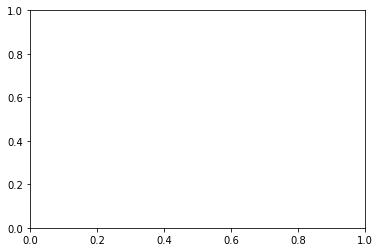

In [6]:
plot_lyap_spec_over_double_range(GS_RANGE, SPARSITIES_RANGE, n_dofs=N_DOFS, n_steps=N_STEPS, normalize_strength=True)


## 3. Vary $S$ & $N$, constant $k$

In [ ]:
# We only go up to $S=0.95$ (which is 20 times as much as the initial DOFS)
N_INIT_DOFS = 100
SN_RANGE = map(lambda s: {"sparsity": s, "n_dofs": int(1 + ((N_INIT_DOFS-1)/(1-s)))}, SPARSITIES[:-2]) 

plot_lyap_spec_over_double_range(GS_RANGE, SPARSITIES_RANGE, n_steps=N_STEPS, normalize_strength=False)


## Appendix

Other things to do:

In [ ]:
# Compare exact same network architectures and relative weights, vary only absolute coupling strength.